In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
%matplotlib inline

### Model

we use 28 $\times$ 28 images belonging to 10 classes, with one-hot encoding


$$\hat{y} = softmax(X\cdot W+b)$$

with:

- $X \in \mathbb{R}^{n\times 784}$, a matrix of $n$ images which have been linearized 
- $W \in \mathbb{R}^{784\times 10}$, a matrix of weights
- $b \in \mathbb{R}^{10}$ a vector of biases (**addition is broadcasted**)
- $softmax:\mathbb{R}^{10}\rightarrow\mathbb{R}^{10}$: $softmax([L_0,...,L_9])=\Big[\frac{e^{L_0}}{||e^L||},...,\frac{e^{L_9}}{||e^L||}\Big]$, with $e^L=[e^{L_0},...,e^{L_9}]$

The $softmax$ function maps a vector $[..,v_i,..]$ into a vector $[..,s_i,..]$ of the same dimensions so that $0<s_i<1$ and $\sum s_i=1$, being interpretable as a probability distribution. 

**The parameters to learn** are $W$ and $b$.

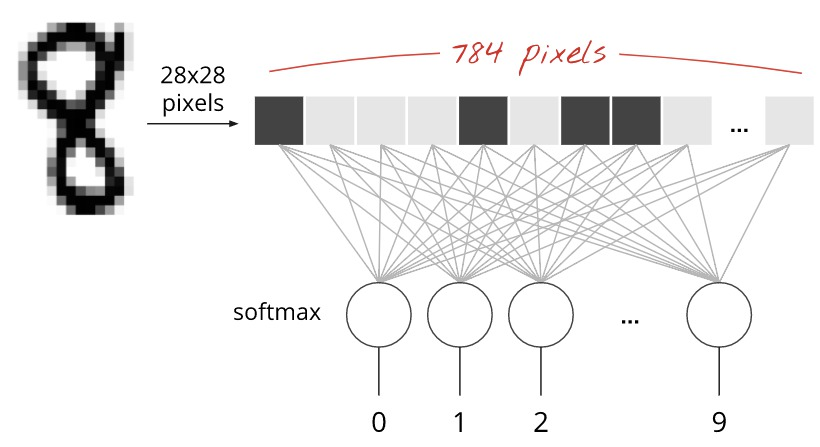

In [2]:
Image(filename='imgs/softmax.jpg', width=600)

###  Cross entropy 

$$loss(y,\hat{y})=-\frac{1}{N}\sum y_i\log(\hat{y}_i)$$

our optimization problem is then minimize the average negative cross entropy:

$$\underset{W,b}{\text{arg min}}\sum_{X_i,y_i \in \text {train_data}} loss(y,\hat{y})$$

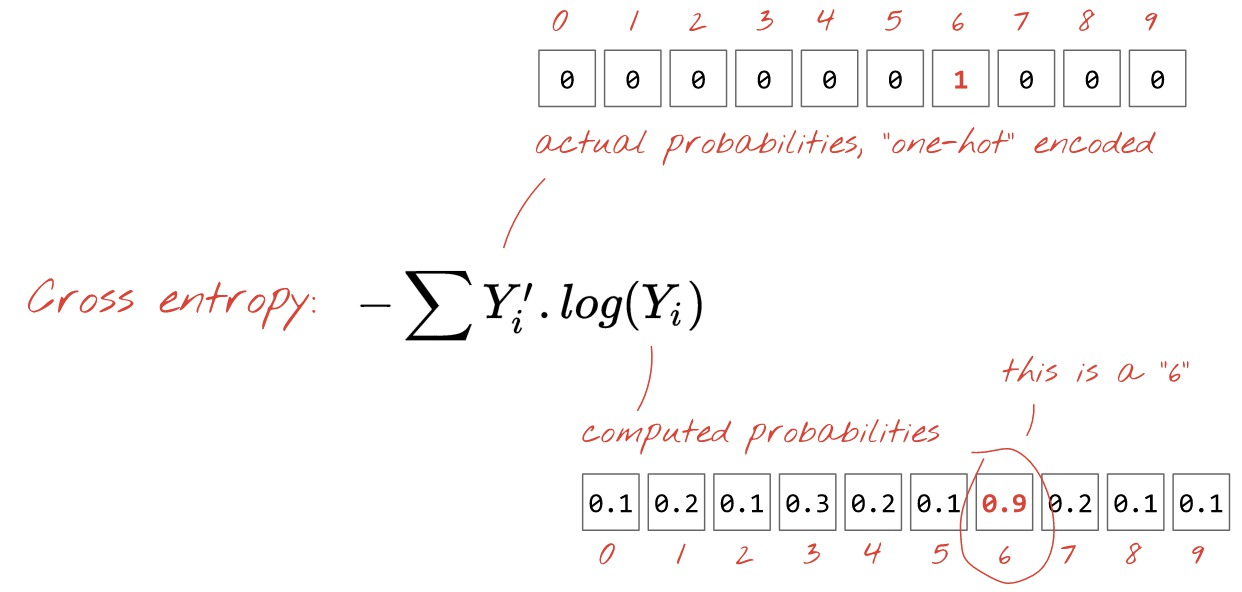

In [3]:
Image(filename='imgs/cross_entropy.jpg', width=600)

### Load dataset

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=True, reshape=False, validation_size=0)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


### Extract train/test

In [5]:
# number of images used for training and test
n=60000

train_imgs = mnist.train.images.reshape(-1,28*28)[:n]
train_ohlabs = mnist.train.labels[:n]
train_labels = np.r_[[np.argwhere(i)[0][0] for i in train_ohlabs]]

In [6]:
test_imgs = mnist.test.images.reshape(-1,28*28)[:n]
test_ohlabs = mnist.test.labels[:n]
test_labels = np.r_[[np.argwhere(i)[0][0] for i in test_ohlabs]]

### Show dataset info and sample images

one hot label [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
numeric label 0


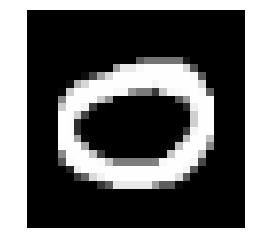

In [7]:
i = np.random.randint(len(train_imgs))
plt.imshow(train_imgs[i].reshape(28,28), cmap=plt.cm.Greys_r)
plt.axis("off")
print "one hot label", train_ohlabs[i]
print "numeric label", train_labels[i]

In [8]:
print pd.Series(train_labels).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64


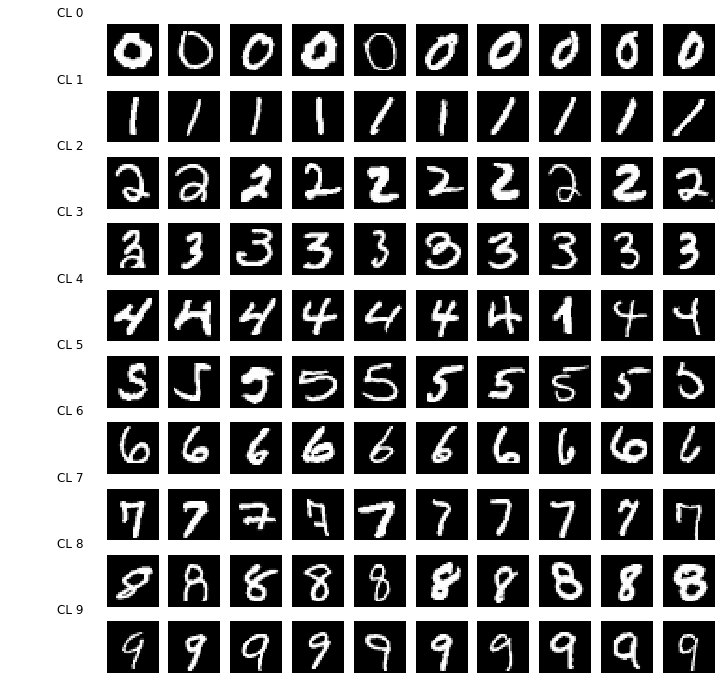

In [9]:
plt.figure(figsize=(12,12))
for lab in np.unique(train_labels):
    k = train_imgs[train_labels==lab]
    for i,idx in enumerate(np.random.permutation(len(k))[:10]):
        if i==0:
            plt.subplot(10,11, lab*11+1)
            plt.title("CL %d"%lab)
            plt.plot(0,0)
            plt.axis("off")

        img = k[idx]
        plt.subplot(10,11, lab*11+i+2)
        plt.imshow(img.reshape(28,28), cmap=plt.cm.Greys_r)
        plt.axis("off")

### Setup computation graph

In [27]:
# Parameters
learning_rate = .1
# Network Parameters
num_input = len(train_imgs[0]) # data input size
num_classes = 10 #  total classes 

tf.reset_default_graph()

# tf Graph input
with tf.name_scope("data"):
    X = tf.placeholder("float", [None, num_input])
    Y = tf.placeholder("float", [None, num_classes])
    
with tf.name_scope("weights_biases"):
    W1 = tf.Variable(tf.random_normal([num_input, num_classes]), name="W1")
    b1 = tf.Variable(tf.random_normal([num_classes]), name="b1")
    
with tf.name_scope("layers"):
    sm = tf.exp(tf.add(tf.matmul(X, W1), b1))
    prediction = sm/tf.reshape(tf.reduce_sum(sm, axis=1),(-1,1))
    
with tf.name_scope("loss"):
    # cross entropy
#    loss_op = tf.reduce_mean(tf.reduce_sum(-Y*tf.log(prediction), axis=1))
    loss = tf.reduce_mean(-Y*tf.log(prediction))
    
with tf.name_scope("optimizer"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_step = optimizer.minimize(loss)

with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))    
    

### Setup summarizers

In [28]:
tf.summary.histogram("W1", W1)
tf.summary.histogram("b1", b1)
    
summary_merged = tf.summary.merge_all()
summary_train_accuracy = tf.summary.scalar("train_accuracy", accuracy)
summary_test_accuracy   = tf.summary.scalar("test_accuracy", accuracy)

summary_train_loss = tf.summary.scalar("train_loss", loss)
summary_test_loss   = tf.summary.scalar("test_loss", loss)

### Gradient descent loop

In [29]:
from time import time
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

batch_size = 100
n_epochs   = 40
log_freq   = 1200

# Start training
from rlx.utils import pbar
from rlx.ml import Batches
print train_imgs.shape, test_imgs.shape
with tf.Session() as sess:
    !rm -rf log
    date = !date
    log_name = "log/nn_"+(date[0]+"-bs=%03d_lr=%4.3f"%(batch_size, learning_rate)).replace(" ", "_")
    print "logging to ", log_name
    summary_writer = tf.summary.FileWriter(log_name,sess.graph)

    # Run the initializer
    sess.run(init)

    step = 1
    t1 = time()
    log_train, log_test = [], []

    for epoch in range(n_epochs):
        ndata = 0
        for batch_x, batch_y in Batches([train_imgs, train_ohlabs], batch_size=batch_size, n_epochs=1).get():
            ndata += len(batch_x)
            # Run optimization op (backprop)
            train_acc, _ =sess.run([accuracy, train_step], feed_dict={X: batch_x, Y: batch_y})
            t2 = time()
            print "\repoch %3d/%d step %5d: train acc: %.4f, time: %.3f segs, %7d/%d"%\
                  (epoch, n_epochs, step, train_acc, (t2-t1), ndata, len(train_imgs)),    

            log_train.append([step, t2-t1, train_acc])
            if step==1 or step%log_freq==0:
                test_acc   = sess.run(accuracy, feed_dict = {X: test_imgs, Y: test_ohlabs})
                print "\repoch %3d/%d step %5d: train acc: %.4f, test acc: %.4f, time: %.3f segs, %7d/%d"%\
                      (epoch, n_epochs, step, train_acc, test_acc, (t2-t1), ndata, len(train_imgs))

                log_test.append([step, t2-t1, test_acc])
                summary_item = sess.run(summary_merged, feed_dict = {X: train_imgs, Y: train_ohlabs})  
                summary_writer.add_summary(summary_item, iter)

                summary_item = sess.run(summary_train_accuracy, feed_dict = {X: train_imgs, Y: train_ohlabs})  
                summary_writer.add_summary(summary_item, iter)
                summary_item = sess.run(summary_test_accuracy, feed_dict = {X: test_imgs, Y: test_ohlabs})  
                summary_writer.add_summary(summary_item, iter)

                summary_item = sess.run(summary_train_loss, feed_dict = {X: train_imgs, Y: train_ohlabs})  
                summary_writer.add_summary(summary_item, iter)
                summary_item = sess.run(summary_test_loss, feed_dict = {X: test_imgs, Y: test_ohlabs})  
                summary_writer.add_summary(summary_item, iter)

            step += 1
    print("Optimization Finished!")
    log_train = pd.DataFrame(log_train, columns=["step", "time", "accuracy"])
    log_test  = pd.DataFrame(log_test, columns=["step", "time", "accuracy"])

    # Calculate accuracy for test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_imgs, Y: test_ohlabs}))
    
    saver = tf.train.Saver()
    saver.save(sess, "models/nn_model.tf")


(60000, 784) (10000, 784)
logging to  log/nn_Thu_Jan_11_20:48:30_COT_2018-bs=100_lr=0.100
epoch   0/40 step     1: train acc: 0.0900, test acc: 0.0498, time: 0.026 segs,     100/60000
epoch   1/40 step  1200: train acc: 0.3900, test acc: 0.4489, time: 3.364 segs,   60000/60000
epoch   3/40 step  2400: train acc: 0.5800, test acc: 0.6189, time: 6.609 segs,   60000/60000
epoch   5/40 step  3600: train acc: 0.6900, test acc: 0.6958, time: 9.859 segs,   60000/60000
epoch   7/40 step  4800: train acc: 0.7200, test acc: 0.7357, time: 13.153 segs,   60000/60000
epoch   9/40 step  6000: train acc: 0.7700, test acc: 0.7597, time: 16.436 segs,   60000/60000
epoch  11/40 step  7200: train acc: 0.8000, test acc: 0.7792, time: 19.851 segs,   60000/60000
epoch  13/40 step  8400: train acc: 0.8300, test acc: 0.7921, time: 23.107 segs,   60000/60000
epoch  15/40 step  9600: train acc: 0.8400, test acc: 0.8051, time: 26.450 segs,   60000/60000
epoch  17/40 step 10800: train acc: 0.8400, test acc: 0.812

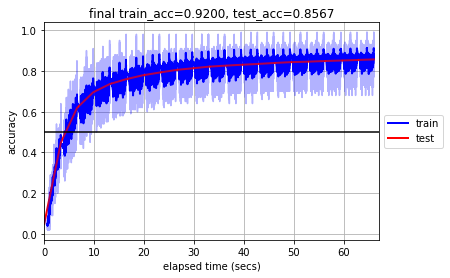

In [30]:
def plot_results(log_train, log_test):
    k = log_train.rolling(window=10).mean().dropna()
    plt.plot(k.time, k.accuracy, color="blue", lw=2, label="train")
    plt.plot(log_test.time, log_test.accuracy, color="red",lw=2, label="test")
    plt.legend(loc="center left", bbox_to_anchor=(1,.5))
    plt.plot(log_train.time, log_train.accuracy, alpha=.3, color="blue")
    plt.grid()
    plt.xlabel("elapsed time (secs)")
    plt.ylabel("accuracy")
    plt.axhline(0.5, color="black")
    plt.xlim(0,log_train.time.max()+1)
    plt.title("final train_acc=%.4f, test_acc=%.4f"%(log_train.accuracy.values[-1], log_test.accuracy.values[-1]))
    
plot_results(log_train, log_test)

### Inspect model (see also TensorBoard)

In [31]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "models/nn_model.tf")
    vW,vb = sess.run([W1,b1])
    test_preds = sess.run(prediction, feed_dict={X:test_imgs})

INFO:tensorflow:Restoring parameters from models/nn_model.tf


In [32]:
vW.shape

(784, 10)

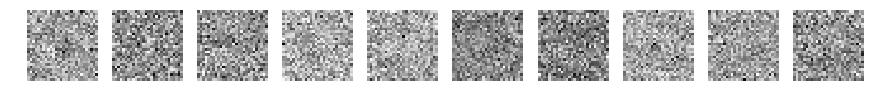

In [33]:
plt.figure(figsize=(15,3))
for i in range(vW.shape[1]):
    plt.subplot(1,vW.shape[1],i+1)
    plt.imshow(vW[:,i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")    

<Container object of 10 artists>

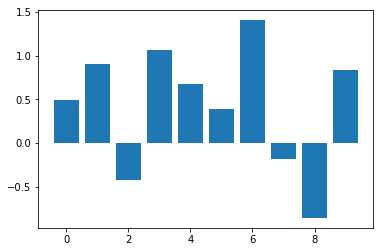

In [34]:
plt.bar(range(len(vb)), vb)

In [35]:
softmax = lambda x: np.exp(x)/np.sum(np.exp(x))


observe value of $X\cdot W +b$ for each output neuron and each input class. This gives an idea of the distinguishability obtained by the network. Diagonal histograms (the response of the output neuron corresponding to the input class) show good detection (all positive). However, some off diagonal histograms are quite mixed, representing cases where the network is more confused.


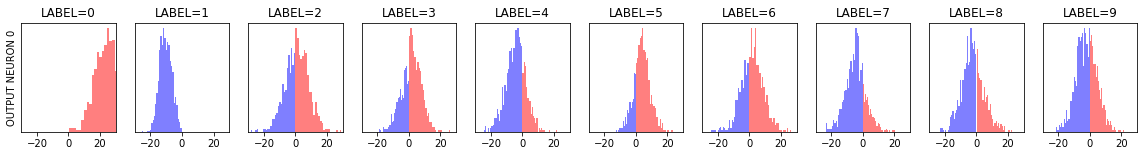

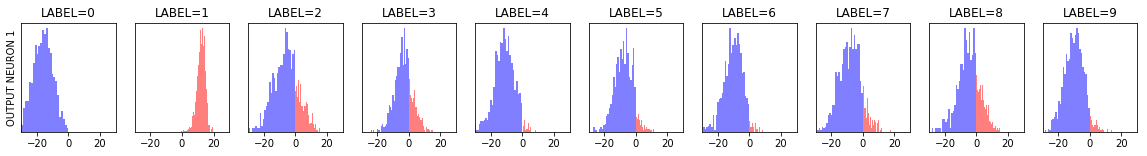

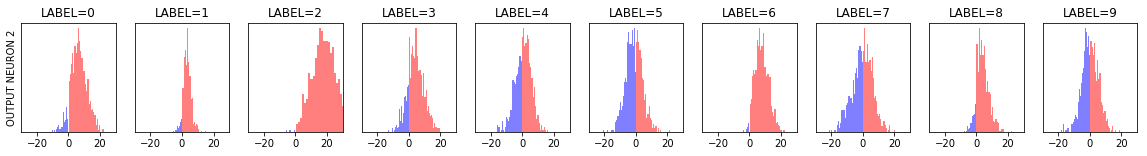

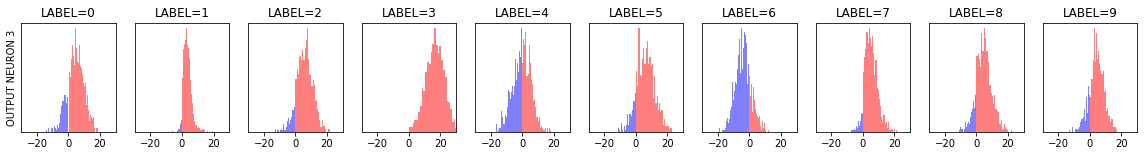

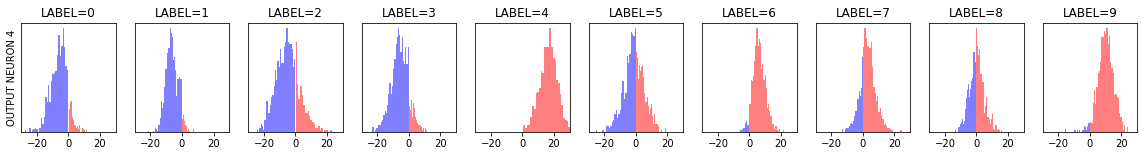

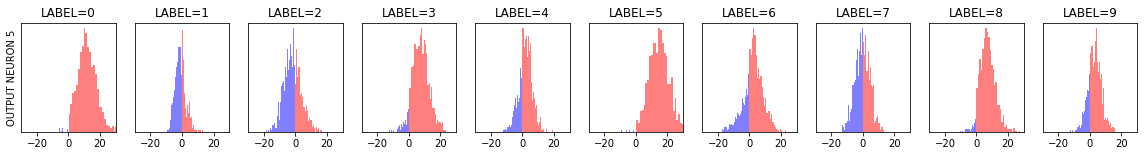

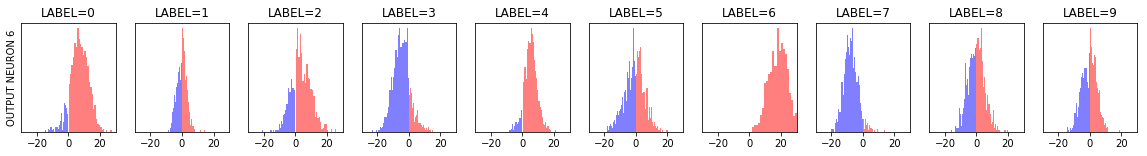

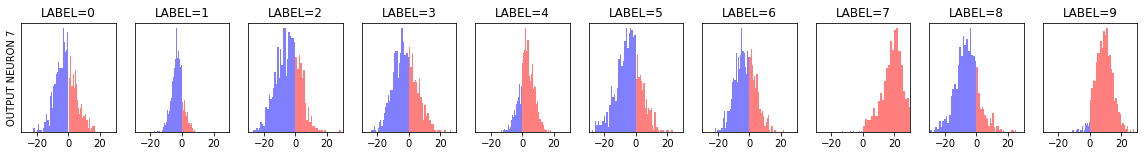

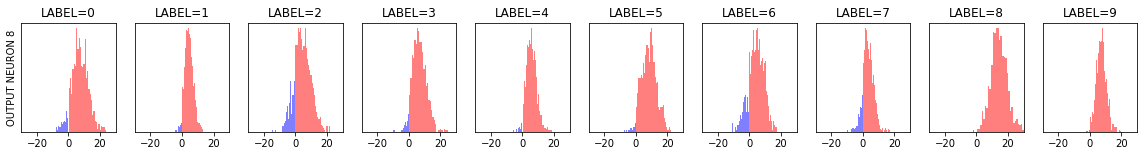

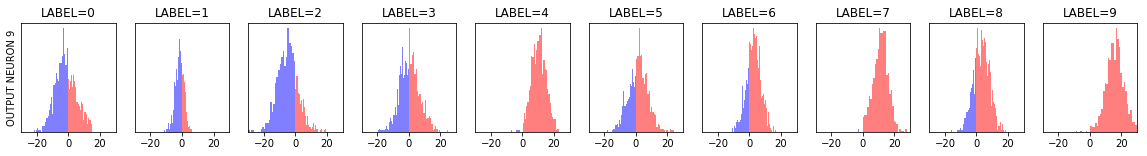

In [36]:
for o in range(10):
    plt.figure(figsize=(20,2))
    for i in np.unique(test_labels):
        plt.subplot(1,10,i+1)
        if i==0:
            plt.ylabel("OUTPUT NEURON %d"%o)
        k = test_imgs[test_labels==i]
        k = (k.dot(vW)+vb)[:,o]
        plt.hist(k[k>0], color="red", alpha=.5, bins=30);
        plt.hist(k[k<0], color="blue", alpha=.5, bins=30);
        plt.title("LABEL="+str(i))
        plt.yticks([])
        plt.xlim(-30,30)


In [37]:
from rlx.ml import confusion_matrix
confusion_matrix(test_labels, np.argmax(test_preds, axis=1))

predicted,0,1,2,3,4,5,6,7,8,9
true,,,,,,,,,,
0,924,0,6,5,0,21,13,2,5,4
1,0,1084,2,14,1,2,5,2,25,0
2,18,7,857,30,15,11,28,10,50,6
3,12,4,26,837,1,61,6,16,34,13
4,2,0,10,8,838,7,17,5,17,78
5,15,6,10,49,23,673,16,16,64,20
6,16,3,16,3,24,23,854,7,7,5
7,3,12,29,12,10,3,3,899,6,51
8,4,14,14,45,14,48,11,17,786,21


### Suggestion

Play with different batch sizes, learning rates and train data size. Observe convergence speed, final accuracy, etc.